In [ ]:
import os
import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import random

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set path to dataset directory
path = '/content/drive/MyDrive/Dataset'

# Get image file extensions
image_extensions = ['.jpg', '.jpeg', '.png']

# Count images in each class
class_dist = Counter()

for ext in image_extensions:
    pattern = os.path.join(path, f'**/*{ext}')
    files = glob.glob(pattern, recursive=True)
    for file in files:
        dir_name = os.path.basename(os.path.dirname(file))
        class_dist[dir_name] += 1

# Display class distribution
for dir_name, count in class_dist.items():
    print(f"There are \033[34m{count}\033[0m images in the {dir_name} folder.")


There are 896 images in the Mild_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 64 images in the Moderate_Demented folder.


In [ ]:
# Create a DataFrame from the class distribution data
df = pd.DataFrame(list(class_dist.items()), columns=['folder', 'image_count'])
df_sorted = df.sort_values(by='image_count', ascending=False)
df

,folder,image_count
0,Mild_Demented,896
1,Very_Mild_Demented,2240
2,Non_Demented,3200
3,Moderate_Demented,64


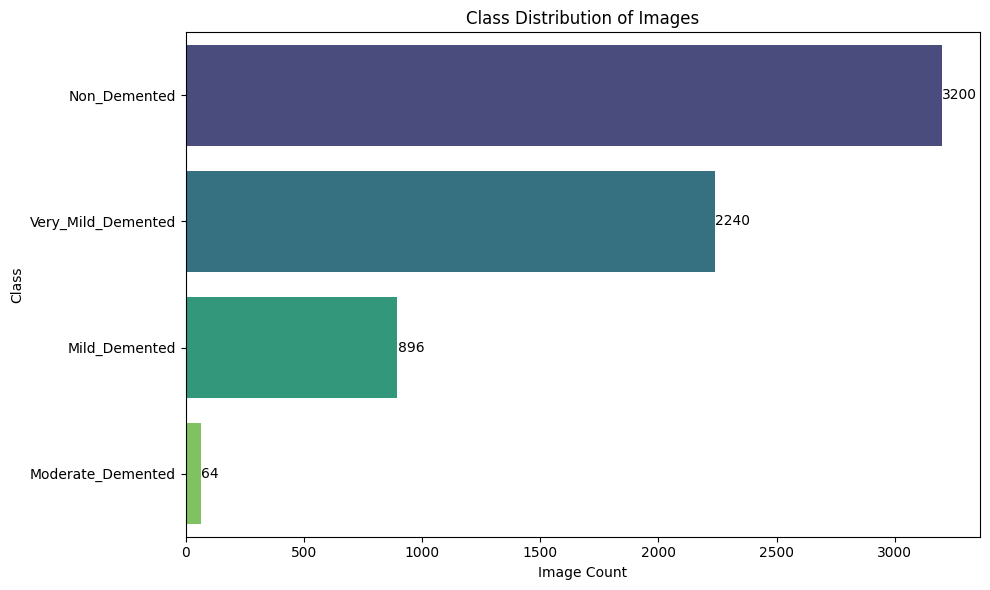

In [ ]:
# Plot class distribution
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='image_count', y='folder', data=df_sorted, palette='viridis', orient='h')
plt.xlabel('Image Count')
plt.ylabel('Class')
plt.title('Class Distribution of Images')

# Add values on the end of each bar
for index, value in enumerate(df_sorted['image_count']):
    plt.text(value + 0.2, index, str(value), color='black', va='center')

plt.tight_layout()
plt.show()

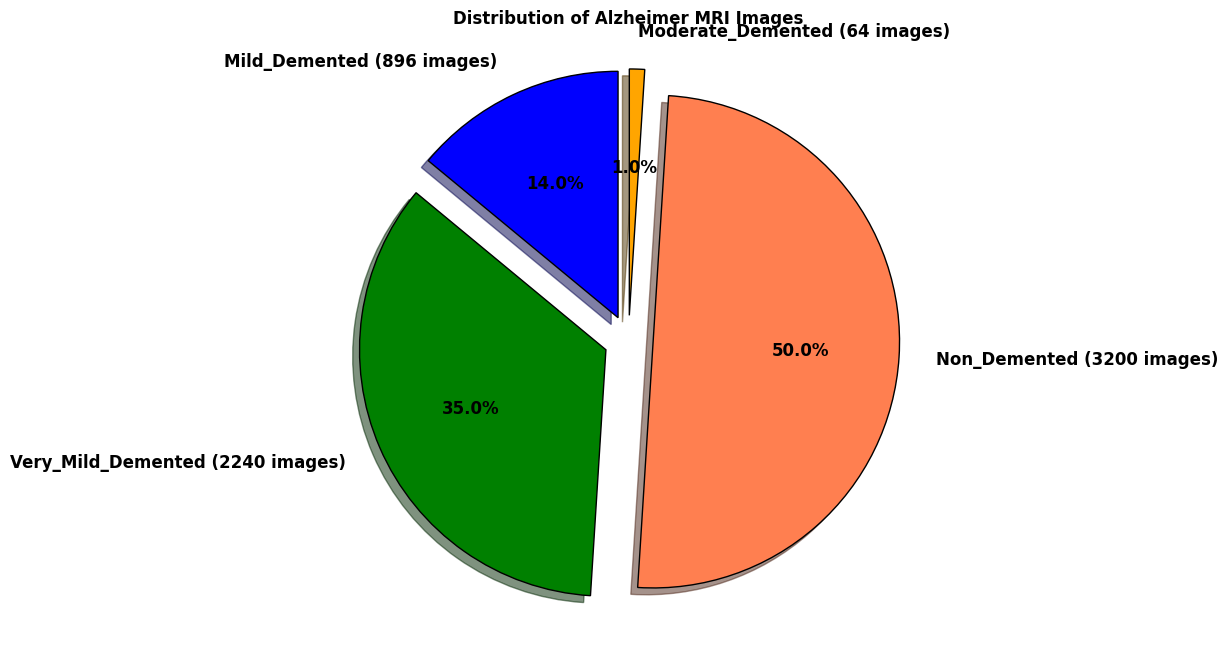

In [ ]:
# Extract keys and values from class_dist
keys = list(class_dist.keys())
values = list(class_dist.values())

# Define colors for the pie chart
colors = ['blue', 'green', 'coral', 'orange']

# Create labels for the pie chart
labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

# Define explode values for the pie chart
explode = (0.1,) * len(keys)

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors,
        textprops={'fontsize': 12, "fontweight": "bold", "color": "black"},
        wedgeprops={'edgecolor': 'black'}, labeldistance=1.15)
plt.title("Distribution of Alzheimer MRI Images", size=12, fontweight="bold")
plt.show()

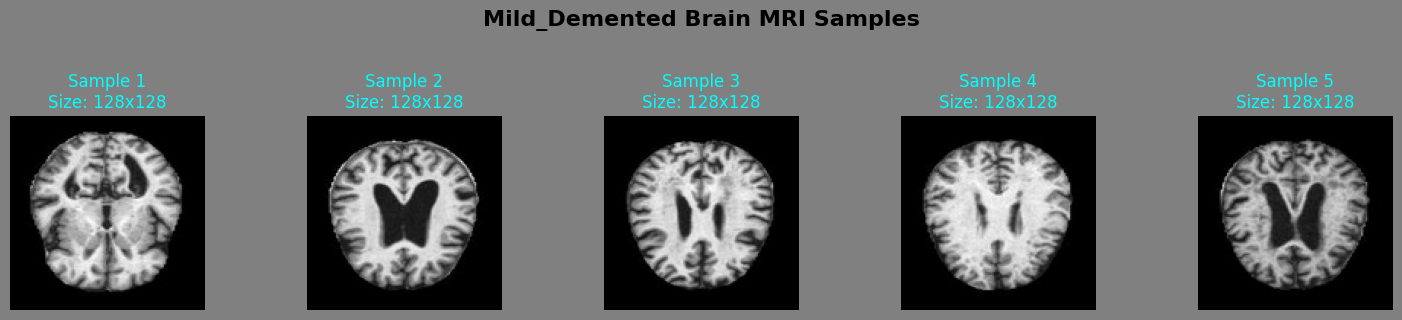

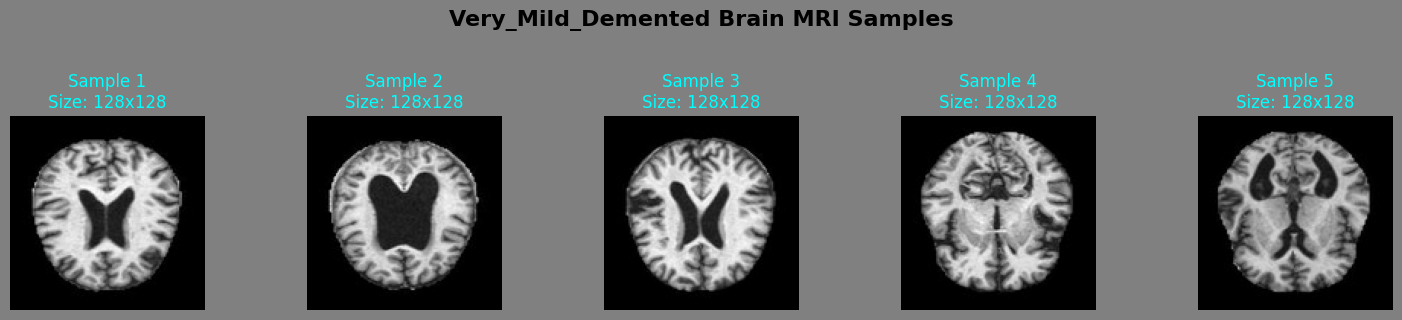

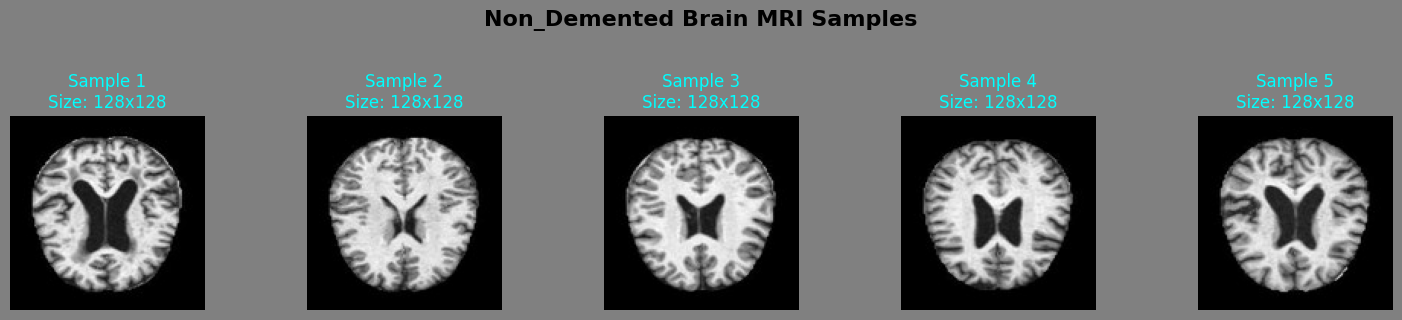

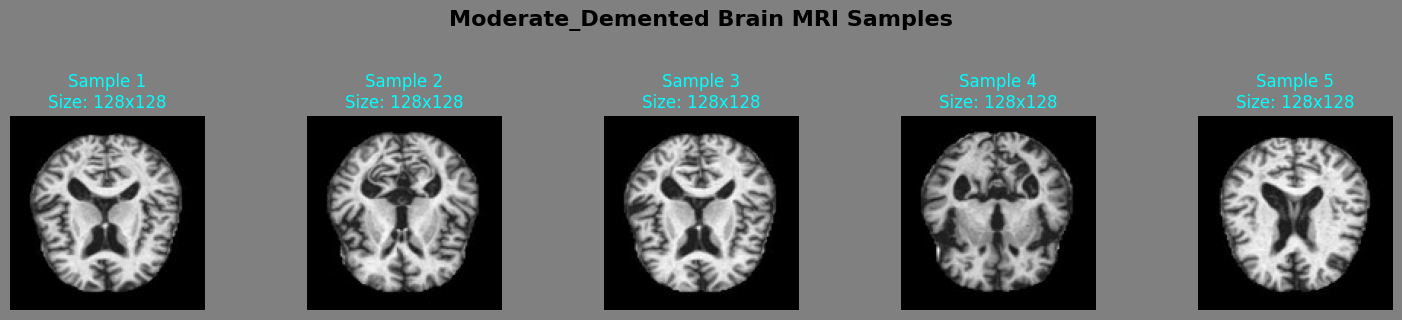

In [ ]:
# Set Seaborn style
sns.set_style("whitegrid")

class_names = os.listdir(path)
num_samples = 5

for target in class_names:
    class_path = os.path.join(path, target)
    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray", figsize=(15, 3))
    fig.suptitle(f'{target} Brain MRI Samples', color="black", fontsize=16, fontweight='bold', y=1.05)  # Adjust y position

    plt.subplots_adjust(top=0.8)  # Adjust top margin

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])

        # Load the image using OpenCV
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Get the dimensions of the image
        height, width, _ = img.shape

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}\nSize: {width}x{height}', color="aqua")

    plt.tight_layout()
    plt.show()

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    path,
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42
)

class_names = data.class_names

# Print the class names
print("Class Names:", class_names)

Found 6400 files belonging to 4 classes.
Class Names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [ ]:
# Preprocess the data by normalizing pixel values
data_normalized = data.map(lambda x, y: (x / 255, tf.one_hot(y, len(class_names))))

In [ ]:
# Split dataset into train, validation, and test sets
def split_dataset(data, train_size=0.8, val_size=0.1, test_size=0.1):
    # Calculate sizes
    num_samples = len(data)
    train_samples = int(num_samples * train_size)
    val_samples = int(num_samples * val_size)
    test_samples = int(num_samples * test_size)

    # Split the dataset
    train_data = data.take(train_samples)
    val_data = data.skip(train_samples).take(val_samples)
    test_data = data.skip(train_samples + val_samples).take(test_samples)

    return train_data, val_data, test_data

train_data, val_data, test_data = split_dataset(data_normalized)

Min and max pixel values in the batch -> 0.0 & 1.0


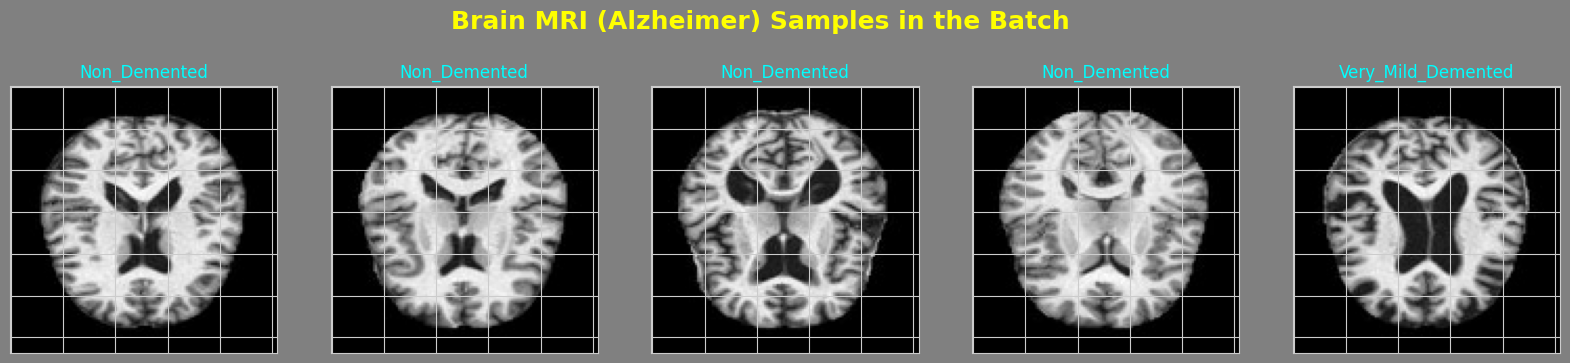

In [ ]:
# Create a new batch
batch = data_normalized.as_numpy_iterator().next()
text = "Min and max pixel values in the batch ->"
print(text, batch[0].min(), "&", batch[0].max())

# Show batch images
number_of_images = 5
fig, ax = plt.subplots(ncols=number_of_images, figsize=(20, 20), facecolor="gray")
fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow", fontsize=18, fontweight='bold', y=0.6)
for idx, img in enumerate(batch[0][:number_of_images]):
    ax[idx].imshow(img)
    class_no = batch[1][idx]
    predicted_class = np.argmax(class_no)  # Get the index of the predicted class
    ax[idx].set_title(class_names[predicted_class], color="aqua")  # Access class names using the predicted class index
    ax[idx].set_xticklabels([])
    ax[idx].set_yticklabels([])

plt.show()

Batch 1 : {'Mild_Demented': 9, 'Moderate_Demented': 0, 'Non_Demented': 11, 'Very_Mild_Demented': 12}
Batch 2 : {'Mild_Demented': 5, 'Moderate_Demented': 0, 'Non_Demented': 15, 'Very_Mild_Demented': 12}
Batch 3 : {'Mild_Demented': 2, 'Moderate_Demented': 0, 'Non_Demented': 18, 'Very_Mild_Demented': 12}
Batch 4 : {'Mild_Demented': 7, 'Moderate_Demented': 1, 'Non_Demented': 14, 'Very_Mild_Demented': 10}
Batch 5 : {'Mild_Demented': 3, 'Moderate_Demented': 1, 'Non_Demented': 17, 'Very_Mild_Demented': 11}
Batch 6 : {'Mild_Demented': 4, 'Moderate_Demented': 0, 'Non_Demented': 20, 'Very_Mild_Demented': 8}
Batch 7 : {'Mild_Demented': 5, 'Moderate_Demented': 0, 'Non_Demented': 15, 'Very_Mild_Demented': 12}
Batch 8 : {'Mild_Demented': 7, 'Moderate_Demented': 0, 'Non_Demented': 15, 'Very_Mild_Demented': 10}
Batch 9 : {'Mild_Demented': 5, 'Moderate_Demented': 0, 'Non_Demented': 15, 'Very_Mild_Demented': 12}
Batch 10 : {'Mild_Demented': 3, 'Moderate_Demented': 1, 'Non_Demented': 19, 'Very_Mild_Demen

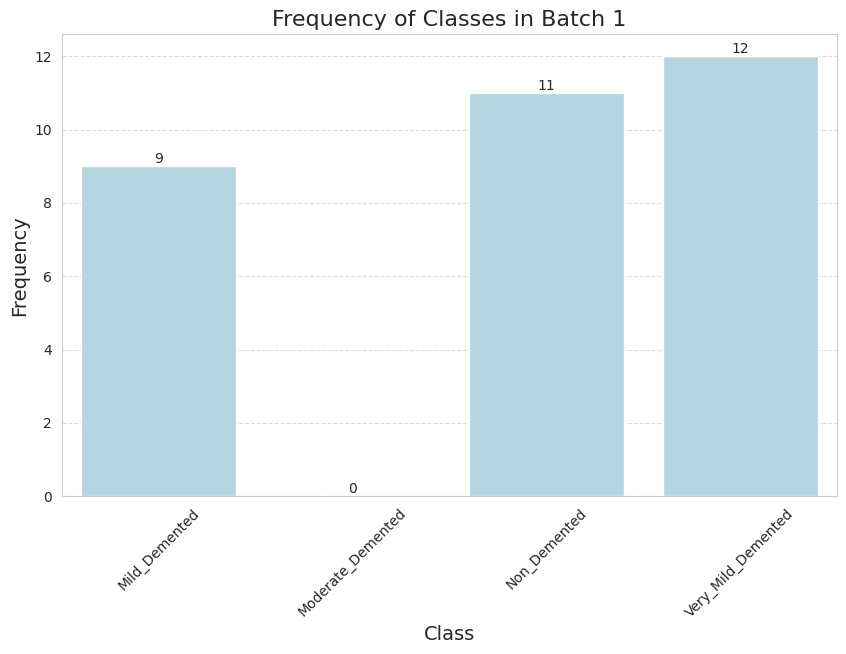

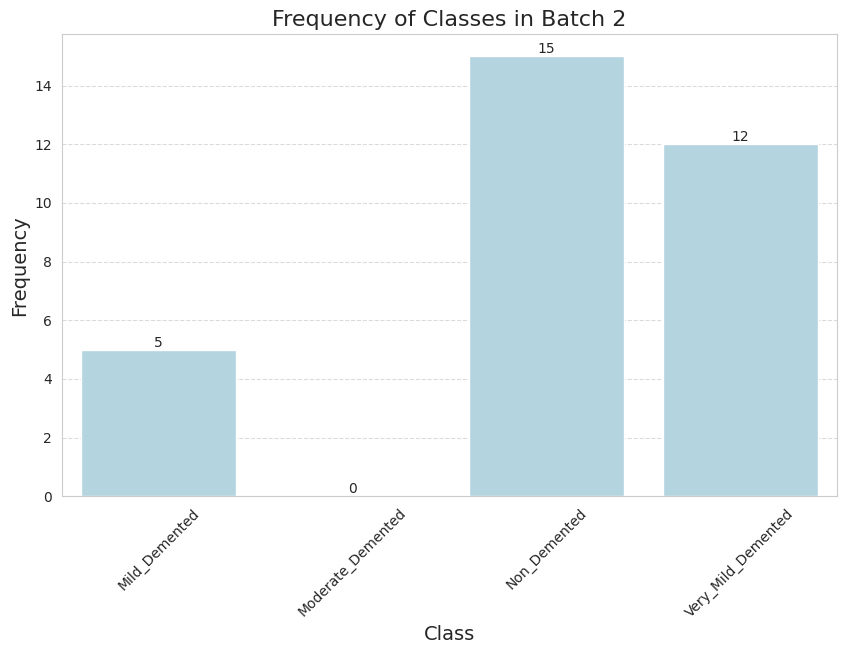

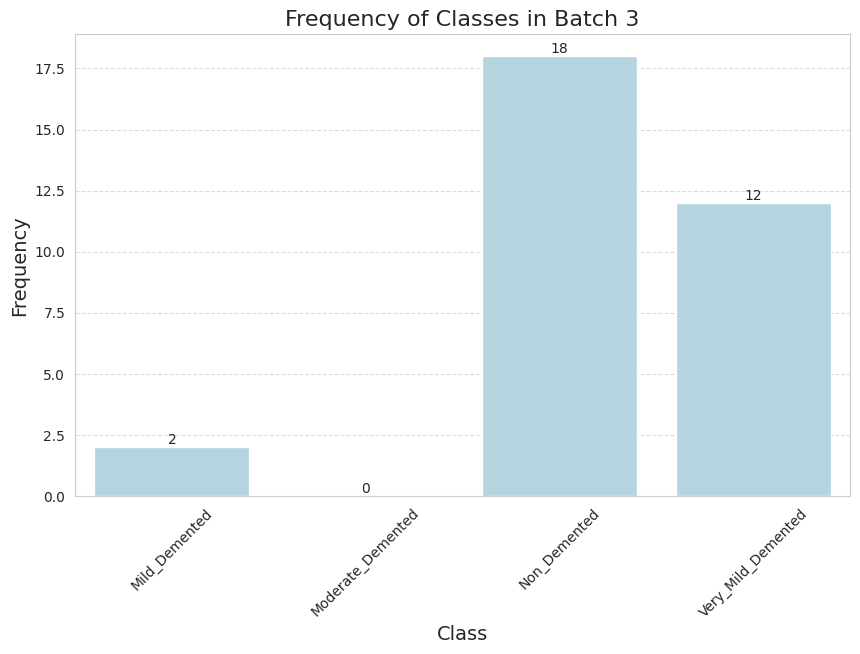

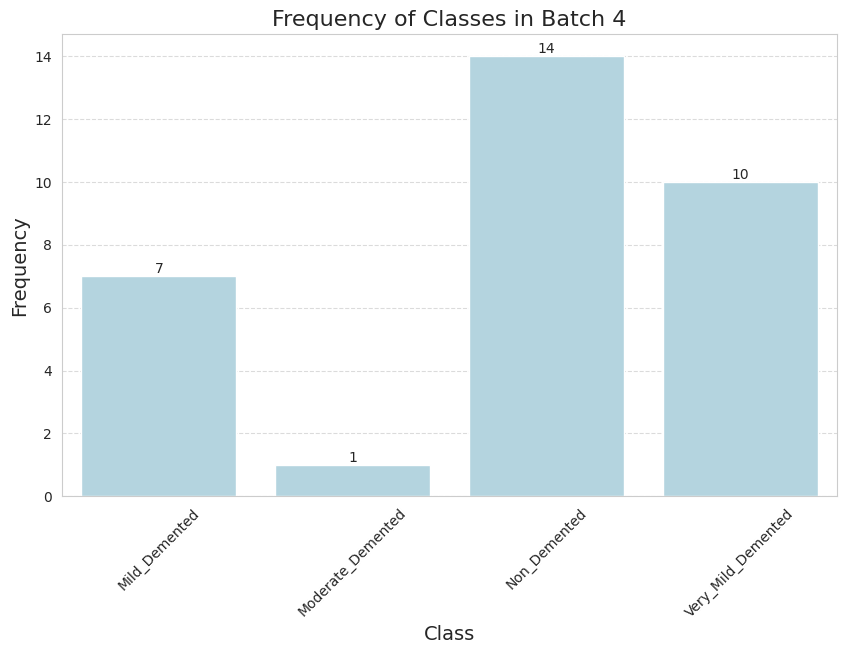

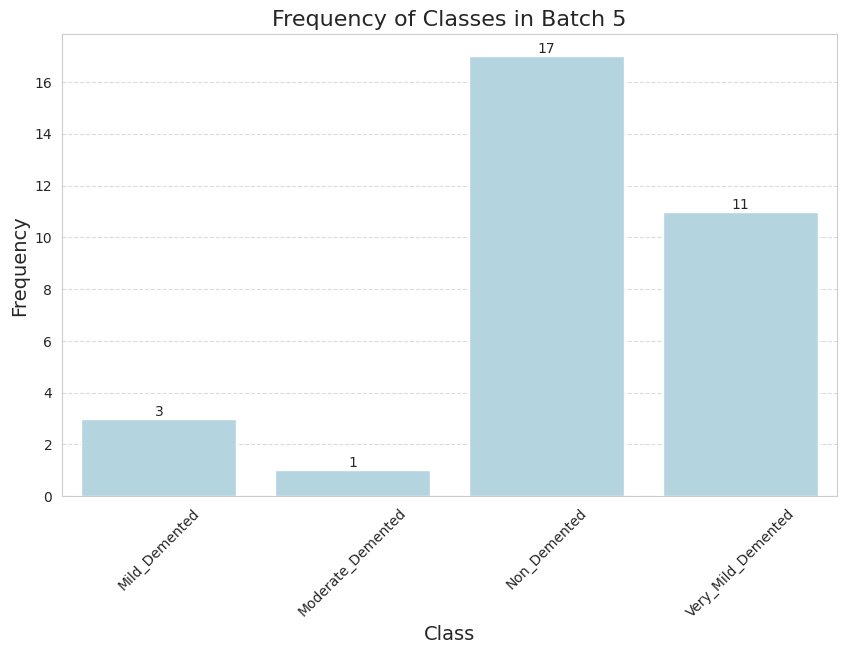

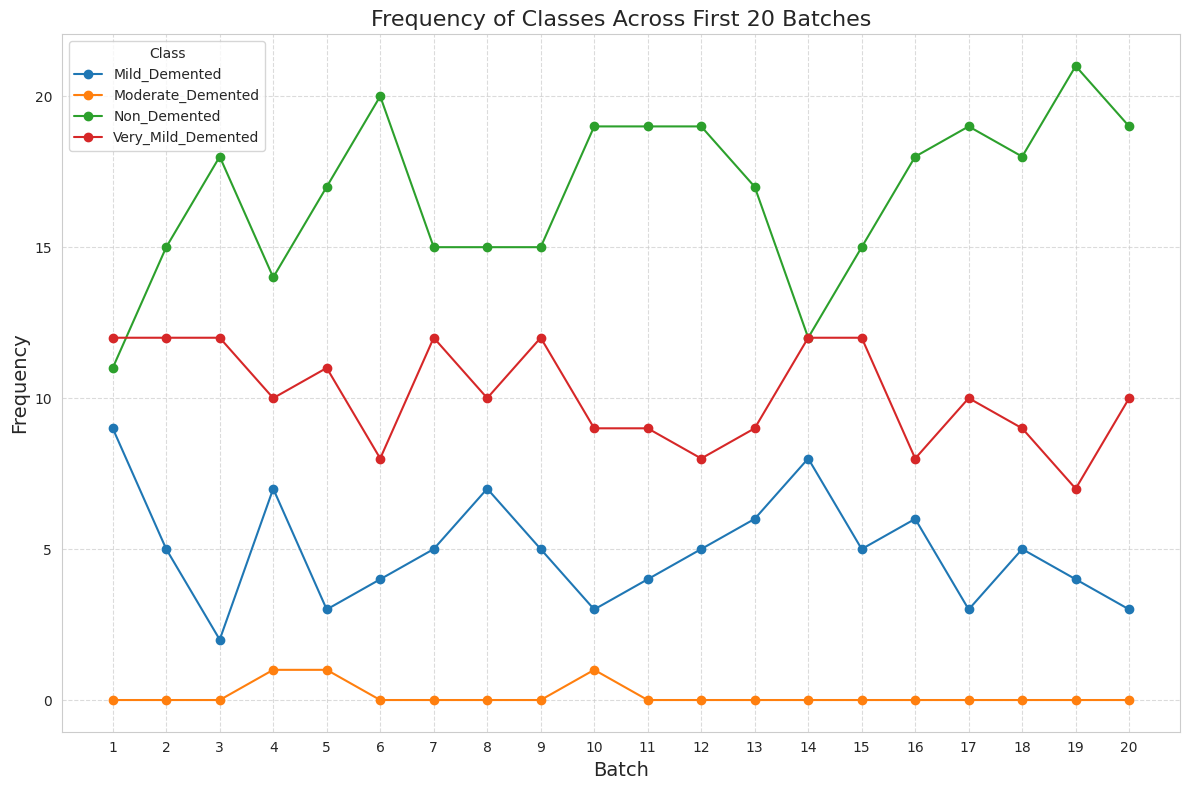

In [ ]:
# Initialize a list to store frequencies of each batch
batch_frequencies = []

# Iterate over all batches and print frequencies
for batch_index, batch in enumerate(data_normalized.as_numpy_iterator(), start=1):
    batch_count = {class_name: 0 for class_name in class_names}  # Initialize class count for the batch
    for class_no in batch[1]:
        predicted_class = np.argmax(class_no)
        batch_count[class_names[predicted_class]] += 1
    batch_frequencies.append(batch_count)
    print("Batch", batch_index, ":", batch_count)

# Plotting the frequency of each batch separately for the first five batches
for batch_index, batch_count in enumerate(batch_frequencies[:5], start=1):
    plt.figure(figsize=(10, 6))
    batch_counts_df = pd.DataFrame(list(batch_count.items()), columns=['Class', 'Frequency'])
    sns.barplot(data=batch_counts_df, x='Class', y='Frequency', color='lightblue')
    plt.title('Frequency of Classes in Batch {}'.format(batch_index), fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for index, row in batch_counts_df.iterrows():
        plt.text(index, row['Frequency'], round(row['Frequency'], 2), ha='center', va='bottom')
    plt.show()

# Plotting line plot for the frequencies of first 20 batches
plt.figure(figsize=(12, 8))
for class_name in class_names:
    frequencies = [batch[class_name] for batch in batch_frequencies[:20]]
    plt.plot(range(1, 21), frequencies, marker='o', label=class_name)

plt.title('Frequency of Classes Across First 20 Batches', fontsize=16)
plt.xlabel('Batch', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(1, 21))
plt.legend(title='Class', fontsize='medium')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Concatenate all labels from the training dataset
y_train = tf.concat([labels for _, labels in train_data], axis=0)
y_train = tf.argmax(y_train, axis=1)  # Convert one-hot encoded labels to scalar values

# Calculate class weights
class_weight = compute_class_weight('balanced', classes=tf.unique(y_train)[0].numpy(), y=y_train.numpy())
class_weights = dict(zip(tf.unique(y_train)[0].numpy(), class_weight))

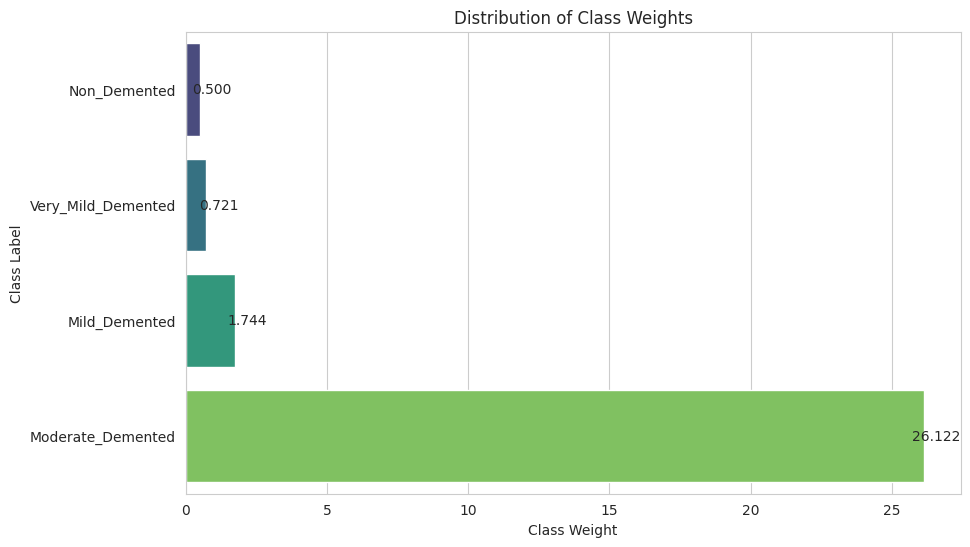

In [ ]:
# Get the names of class labels
class_labels = [class_names[label] for label in class_weights.keys()]

# Create a DataFrame with class labels and weights
df_class_weights = pd.DataFrame({'Class Label': class_labels, 'Class Weight': list(class_weights.values())})

# Plot the distribution of class weights using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class Weight', y='Class Label', data=df_class_weights, palette='viridis')

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.3f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = 'center', va = 'center',
                xytext = (9, 0),
                textcoords = 'offset points')

plt.xlabel('Class Weight')
plt.ylabel('Class Label')
plt.title('Distribution of Class Weights')
plt.show()

In [ ]:
# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

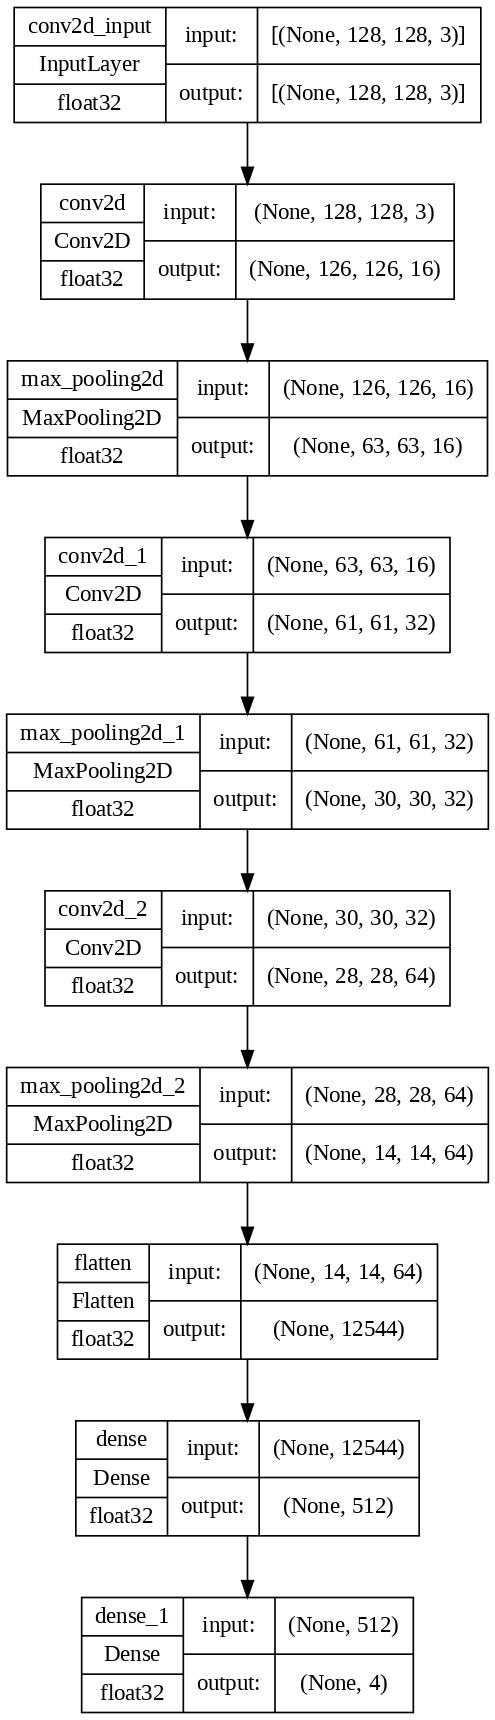

In [ ]:
# Save model summary to a file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Plot the model architecture and save it to a file
tf.keras.utils.plot_model(
    model,
    to_file='model.png',       # File path to save the plot
    show_shapes=True,          # Show shapes of the layers
    show_layer_names=True,     # Show layer names
    show_dtype=True,           # Show layer data types
    dpi=120                    # DPI of the figure
)

In [ ]:
# Define callbacks
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

callbacks = [model_checkpoint_callback, early_stopping]

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
160/160 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.5328
Epoch 1: val_accuracy improved from -inf to 0.60469, saving model to /tmp/checkpoint
160/160 [==============================] - 41s 226ms/step - loss: 0.9853 - accuracy: 0.5328 - val_loss: 0.9443 - val_accuracy: 0.6047
Epoch 2/20
160/160 [==============================] - ETA: 0s - loss: 0.8177 - accuracy: 0.6311
Epoch 2: val_accuracy improved from 0.60469 to 0.65312, saving model to /tmp/checkpoint
160/160 [==============================] - 36s 224ms/step - loss: 0.8177 - accuracy: 0.6311 - val_loss: 0.7788 - val_accuracy: 0.6531
Epoch 3/20
160/160 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7555
Epoch 3: val_accuracy improved from 0.65312 to 0.76875, saving model to /tmp/checkpoint
160/160 [==============================] - 37s 224ms/step - loss: 0.5682 - accuracy: 0.7555 - val_loss: 0.5232 - val_accuracy: 0.7688
Epoch 4/20
160/160 [=============================

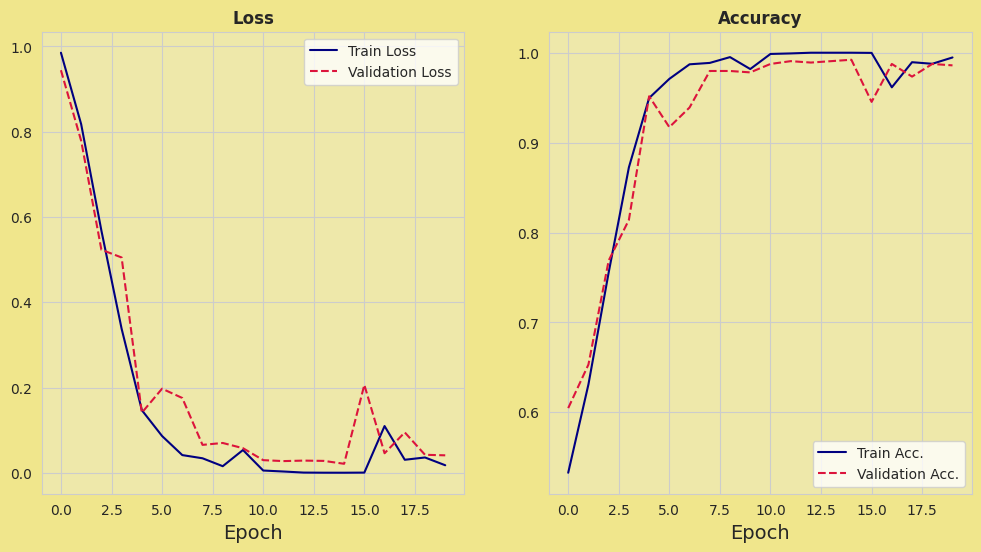

In [ ]:
# Plot Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 16s 60ms/step - loss: 0.0432 - accuracy: 0.9828
Test Loss: 0.04320646449923515
Test Accuracy: 0.9828125238418579


In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(np.argmax(y, axis=1))  # Convert one-hot encoded labels to multiclass

# Convert predictions and labels to numpy arrays
predictions = np.array(predictions)
labels = np.array(labels)

# Print the classification report
print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.94      0.97        82
 Moderate_Demented       1.00      1.00      1.00         5
      Non_Demented       0.98      1.00      0.99       318
Very_Mild_Demented       0.98      0.97      0.98       235

          accuracy                           0.98       640
         macro avg       0.99      0.98      0.98       640
      weighted avg       0.98      0.98      0.98       640



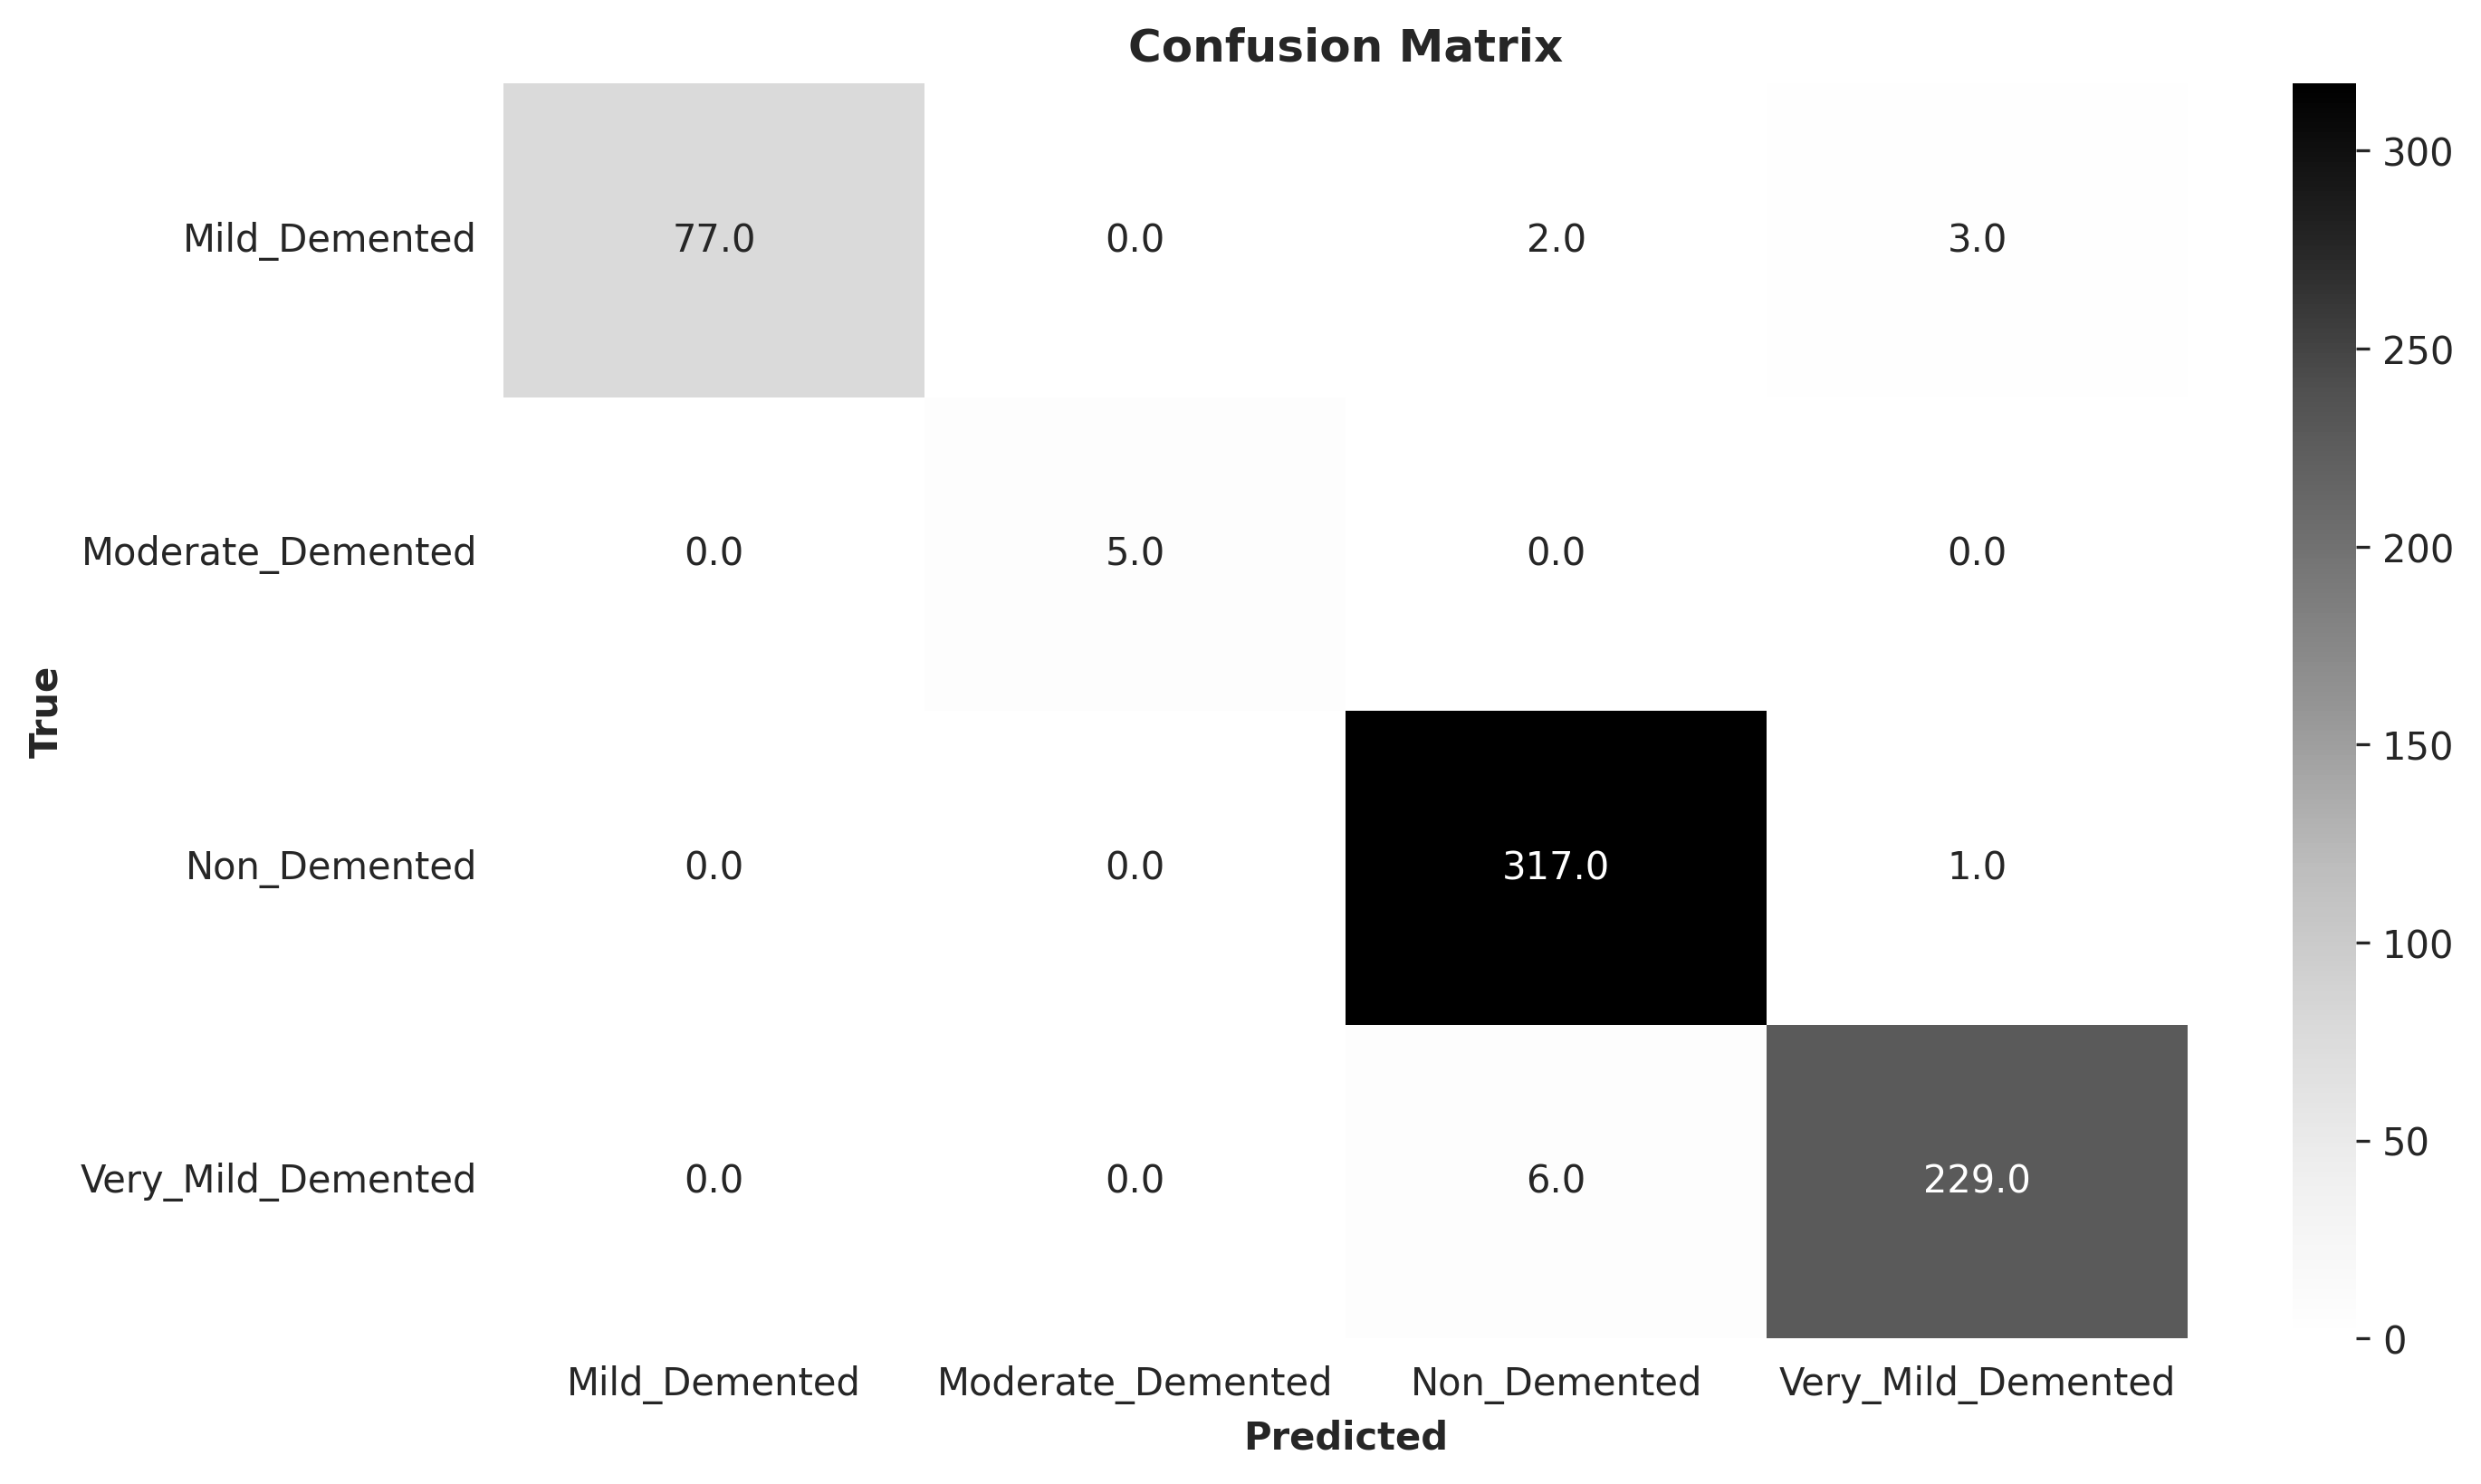

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")
plt.show()


In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for idx, (images, labels) in enumerate(test_data.take(1)):
    predictions = model.predict(images, verbose=0)
    for i in range(min(len(images), 25)):  # Limit loop to 25 iterations
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])

        score = tf.nn.softmax(predictions[i])
        predicted_class = np.argmax(score).item()  # Ensure scalar integer

        if len(labels[i]) > 1:
            actual_class = np.argmax(labels[i]).item()  # Extract scalar integer from one-hot encoded label
        else:
            actual_class = labels[i].numpy().item()  # Ensure scalar integer

        if class_names[actual_class] == class_names[predicted_class]:
            plt.title("Actual: " + class_names[actual_class], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: " + class_names[predicted_class], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
        else:
            plt.title("Actual: " + class_names[actual_class], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: " + class_names[predicted_class], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))

        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Base Model:
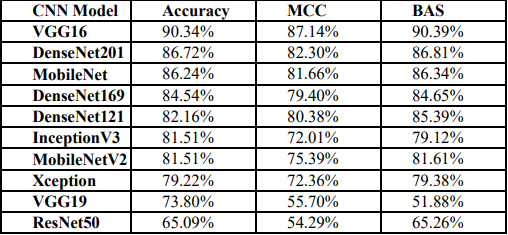

To run the model goto Runtime and click Run all to view the results.